# 1. Build your own convolutional neural network using pytorch

In [1]:
import os
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

In [2]:
os.listdir('./')

['.config', 'sample_data']

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/My\ Drive/Project1_CV

/content/drive/My Drive/Project1_CV


In [5]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
!nvidia-smi

Thu Nov 10 21:16:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
train_data_path = './Train'

In [8]:
test_data_path = './Test/Test1'

In [9]:
training_transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(10),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [10]:
training_data = torchvision.datasets.ImageFolder(root = train_data_path, transform = training_transform)

In [11]:
train_data,val_data = random_split(training_data,[len(training_data)-149,149])

In [12]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=32, shuffle = True)

In [13]:
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=32, shuffle = False)

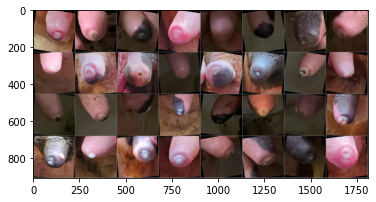

In [14]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [15]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # n = 224
        self.conv1 = nn.Conv2d(3, 64, 3)  # 222
        self.conv2 = nn.Conv2d(64, 64, 3) # 220
        self.pool1 = nn.MaxPool2d(2, 2)   # 110

        self.conv3 = nn.Conv2d(64, 128, 3) # 108
        self.conv4 = nn.Conv2d(128, 128, 3)  # 106
        self.pool2 = nn.MaxPool2d(2, 2) # 53

        self.conv5 = nn.Conv2d(128, 256, 3) # 51
        self.conv6 = nn.Conv2d(256, 256, 3) # 49
        self.conv7 = nn.Conv2d(256, 256, 3) # 47
        self.pool3 = nn.MaxPool2d(2, 2) # 23

        self.conv8 = nn.Conv2d(256, 512, 3) # 21
        self.conv9 = nn.Conv2d(512, 512, 3) # 19
        self.conv10 = nn.Conv2d(512, 32, 3) # 17
        self.pool4 = nn.MaxPool2d(2, 2) # 8

        
        self.fc1 = nn.Linear(8*8*32, 256)
        self.dropout1 = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc3 = nn.Linear(128, 4)
        

    def forward(self, x):
  
        x = F.relu(self.conv1(x))
        x = self.pool1(F.relu(self.conv2(x)))

        x = F.relu(self.conv3(x))
        x = self.pool2(F.relu(self.conv4(x)))

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool3(F.relu(self.conv7(x)))

        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = self.pool4(F.relu(self.conv10(x)))
       

        x = x.view(-1, 8*8*32)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

# 2. Train your model using cow teat datasets (you may need to use Google Colab (or Kaggle) with GPU to train your code)

In [56]:
#model = ConvNet().to(device)
model = torch.load('cnn12_250.pt')

In [57]:
# Define the loss
criterion = nn.CrossEntropyLoss()

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [58]:
epochs = 50
train_losses = []
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
               
        # Training pass
        optimizer.zero_grad()
        
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device))
                
        loss.backward()
        optimizer.step()
        
        #print(loss)
        
        running_loss += loss.item()        
    else:
        print(f"Training loss: {running_loss/len(train_loader)}")
        train_losses.append(running_loss/len(train_loader))

torch.save(model, 'cnn12_300.pt')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Training loss: 0.7184805069118738
Training loss: 0.713314650580287
Training loss: 0.740280270576477
Training loss: 0.7093990370631218
Training loss: 0.7447294620797038
Training loss: 0.723111349157989
Training loss: 0.7360952673479915
Training loss: 0.7613864075392485
Training loss: 0.7259174799546599
Training loss: 0.6721049696207047
Training loss: 0.6475127385929227
Training loss: 0.6612125439569354
Training loss: 0.64633225556463
Training loss: 0.6919907238334417
Training loss: 0.691467147320509
Training loss: 0.6706983391195536
Training loss: 0.6230040248483419
Training loss: 0.6040456751361489
Training loss: 0.6069013634696603
Training loss: 0.6199893020093441
Training loss: 0.5903077609837055
Training loss: 0.6009869473055005
Training loss: 0.614419917576015
Training loss: 0.607447219081223
Training loss: 0.6033153114840388
Training loss: 0.6079563172534108
Training loss: 0.5709809930995107
Training loss: 0.5473409332334995
Training loss: 0.6112590013071895
Training loss: 0.52316

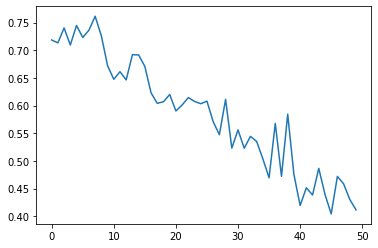

In [59]:
e = [i for i in range(0,50)]
plt.plot(e, train_losses)
plt.show()

In [60]:
correct = 0
total = 0

with torch.no_grad():
    for data in train_loader:
        X,y = data
        outputs = model(X.to(device))
        for idx, i in enumerate(outputs):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
print("Train Accuracy in percentage: ", round(100*correct/total, 3))

Train Accuracy in percentage:  84.1


In [61]:
correct = 0
total = 0

with torch.no_grad():
    for data in val_loader:
        X,y = data
        outputs = model(X.to(device))
        for idx, i in enumerate(outputs):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
print("Validation Accuracy in percentage: ", round(100*correct/total, 3))

Validation Accuracy in percentage:  59.06


# 3. Evaluate your model using the developed software

In [48]:
def import_test_dataset(root_path, resized_size = (224,224)):
  img_data_files = []
  img_data_names = os.listdir(root_path)
  for img in img_data_names:
    path_=os.path.join(root_path, img)
    img = cv2.imread(path_)
    resized = cv2.resize(img, resized_size)
    img_data_files.append(resized)

  return( (np.array(img_data_files),np.array(img_data_names)) )

In [49]:
size_of_resized_img = (224,224)
test_data, test_names = import_test_dataset(test_data_path, resized_size= size_of_resized_img)
print(test_data.shape)
print(test_names.shape)

(380, 224, 224, 3)
(380,)


In [50]:
type(test_data)

numpy.ndarray

In [51]:
predictions_list = []
with torch.no_grad():
  for x in test_data:
    x_tensor = torch.tensor(x.reshape(3,224,224), dtype=torch.float)
    x_tensor = x_tensor[None, :]
    outputs = model(x_tensor.to(device))
    predictions = torch.argmax(outputs, dim=1)
    predictions_list.append(predictions)
len(predictions_list)

380

In [52]:
predictions_list[0]

tensor([1], device='cuda:0')

In [53]:
preds = []
for i in predictions_list:
  preds.append(str(predictions_list[i]).split("[")[1][0])

In [54]:
df = pd.DataFrame(list(zip(test_names,preds)))
df.head(10)

,0,1
0,20200724_094326_LF_C1_PN_M.jpg,1
1,20200724_094529_RH_C1_PP_M.jpg,1
2,20200724_094716_RF_C2_PN_M.jpg,1
3,20200724_094705_RF_C1_PN_M.jpg,3
4,20200724_094644_LF_C2_PN_M.jpg,1
5,20200724_094519_LH_C1_PN_M.jpg,3
6,20200724_094747_RF_C2_PP_M.jpg,1
7,20200724_094414_LF_C2_PP_M.jpg,1
8,20200724_094619_LH_C1_PN_M.jpg,1
9,20200724_094716_LH_C2_PN_M.jpg,1


In [55]:
df.to_csv("Test_results_cnn12.csv", header=False,index=False)

# 4. Compare results with [SCTL paper](https://www.mdpi.com/2076-2615/12/7/886/htm). Requirement: performance is better than VGG16: 66.8%

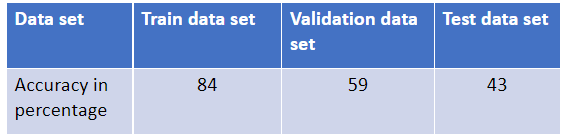

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link here.

https://www.researchgate.net/publication/365297839_Building_a_CNN_model_using_Pytorch_to_classify_cow_teats_images

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points